# Importation des librairies

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import yaml
import torch

sys.path.append(os.path.dirname("../src"))

%matplotlib inline

['Feature_selection_wrapper.ipynb', 'random_forest.ipynb', 'README.md', 'feature_importance_nn.ipynb', 'random_forest_gridsearch.ipynb']


In [75]:
with open('../src/config.yaml', "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.Loader)

# Chargement des données

In [76]:
from src.data.dataset_utils import basic_random_split, merge_files, RegressionDataset
from torch.utils.data import DataLoader

path_to_data = cfg["DATA_DIR"]

data, features_name = basic_random_split(
        path_to_data=path_to_data,
        preprocessing=cfg["DATASET"]["PREPROCESSING"],
        test_valid_ratio=cfg["DATASET"]["TEST_VALID_RATIO"],
        which=cfg["DATASET"]["PREPROCESSING"]["MERGE_FILES"]["WHICH"],
    )

target_to_predict = cfg["DATASET"]["PREPROCESSING"]["TARGET"]
print(f"\nYou want to predict : {cfg['DATASET']['PREPROCESSING']['TARGET']}")

x_train, y_train, x_valid, y_valid, x_test, y_test = merge_files(
    data=data, target_to_predict=target_to_predict
)

# Create train, valid and test dataset
train_dataset = RegressionDataset(
    x_data=torch.from_numpy(x_train).float(),
    y_data=torch.from_numpy(y_train).float(),
)
valid_dataset = RegressionDataset(
    x_data=torch.from_numpy(x_valid).float(),
    y_data=torch.from_numpy(y_valid).float(),
)
test_dataset = RegressionDataset(
    x_data=torch.from_numpy(x_test).float(), y_data=torch.from_numpy(y_test).float()
)

# DataLoader

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=cfg["DATASET"]["BATCH_SIZE"],
    num_workers=cfg["DATASET"]["NUM_THREADS"],
    shuffle=False,
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=cfg["DATASET"]["BATCH_SIZE"],
    shuffle=False,
    num_workers=cfg["DATASET"]["NUM_THREADS"],
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=cfg["TEST"]["BATCH_SIZE"],
    shuffle=False,
    num_workers=cfg["DATASET"]["NUM_THREADS"],
)


#################
# Loading files #
#################

You selected : ['DP980GA_Galma1_upgrade.csv' 'DP980GI_SDG3-v2_20220208_upgrade.csv'
 'DP980GI_SDG3.5_20220208_upgrade.csv' 'DP980Y700_EKO1_upgrade.csv'
 'DP980Y700_SDG3_2021_upgrade.csv' 'DP980_Sagunto_2021_upgrade.csv']



100%|██████████| 6/6 [00:00<00:00, 355.99it/s]


###################
# Remove features #
###################

You removed : 
	['Coilnr', 'Date', 'Linespeed (m/min)', 'B ppm']

You want to predict : rm


# Chargement du modèle

In [77]:
import torch.nn as nn
from tools.utils import load_model

# Define device for computational efficiency
if not torch.cuda.is_available():
    device = torch.device("cpu")
else:
    device = torch.device("cuda")

# Load model for inference
input_size = train_loader.dataset[0][0].shape[0]

# Define the loss
f_loss = nn.MSELoss()

# Load model
model_path = cfg["TEST"]["PATH_TO_MODEL"]
model = load_model(
    cfg=cfg,
    input_size=input_size,
    num_hidden_neuron=cfg["TRAIN"]["NUM_HIDDEN_NEURON"],
)
model = model.to(device)

model.load_state_dict(torch.load(model_path))
model.eval()

LinearNet_3(
  (layer_1): Linear(in_features=20, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drops): Dropout(p=0.1, inplace=False)
)

In [88]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(model)
attributions_ig, delta_ig = ig.attribute(train_loader.dataset.x_data, return_convergence_delta=True)


In [89]:
result = pd.DataFrame(np.concatenate((np.array(features_name).reshape(-1, 1), abs(np.mean(np.array(attributions_ig), axis=0).reshape(-1, 1))), axis=1), columns=['x', 'y'])

Text(0, 0.5, 'Feature Names')

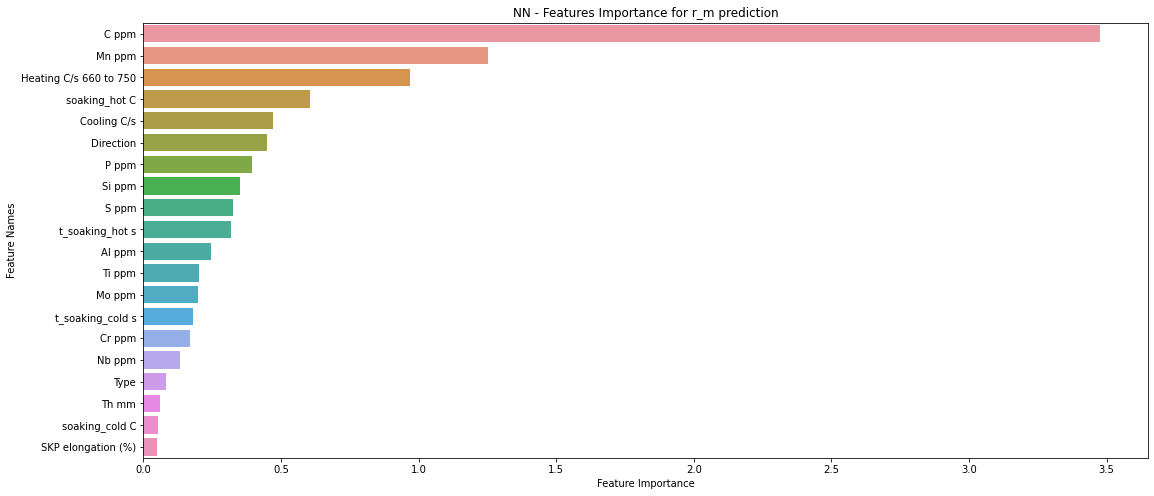

In [90]:
result.sort_values(by=["y"], ascending=False, inplace=True)
# Define size of bar plot
fig = plt.figure(figsize=(18, 8))
# Plot Searborn bar chart
sns.barplot(x='y', y='x', data=result)
# Add chart labels
plt.title(f"NN - Features Importance for r_m prediction")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")